In [1]:
from jwave.geometry import Domain, Medium, TimeAxis, _circ_mask
from jwave.acoustics.time_varying import simulate_wave_propagation
from jwave import FiniteDifferences, FourierSeries
from jwave.signal_processing import smooth

from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import jax
import matplotlib

In [2]:
domain = Domain((128,128), (0.1e-3,0.1e-3))

# Heterogeneous sound speed
sound_speed = np.ones(domain.N) * 1500.0
sound_speed[50:90, 32:100] = 2300.0

# Smoothed initial pressure distribution
Nx = domain.N
p0 = 5.0 * _circ_mask(Nx, 5, (40, 40))

# Getting time axis
medium = Medium(domain, sound_speed, pml_size=16)
time_axis = TimeAxis.from_medium(medium, cfl=0.1, t_end=4e-6)

In [3]:
@jax.jit
def run_simulation(p0, sound_speed):
    medium = Medium(domain, sound_speed, pml_size=16)
    return simulate_wave_propagation(
      medium,
      time_axis,
      p0=p0,
      smooth_initial=True
    )

In [4]:
p0_fd = FiniteDifferences(np.expand_dims(p0, -1), domain, accuracy=8)
sos_fd = FiniteDifferences(np.expand_dims(sound_speed, -1), domain, accuracy=8)

pred_fields_fd = run_simulation(p0_fd, sos_fd)

In [5]:
p0_fd = FourierSeries(np.expand_dims(p0, -1), domain)
sos_fd = FourierSeries(np.expand_dims(sound_speed, -1), domain)

pred_fields_fourier = run_simulation(p0_fd, sos_fd)

Text(0.5, 1.0, 'FourierSeries')

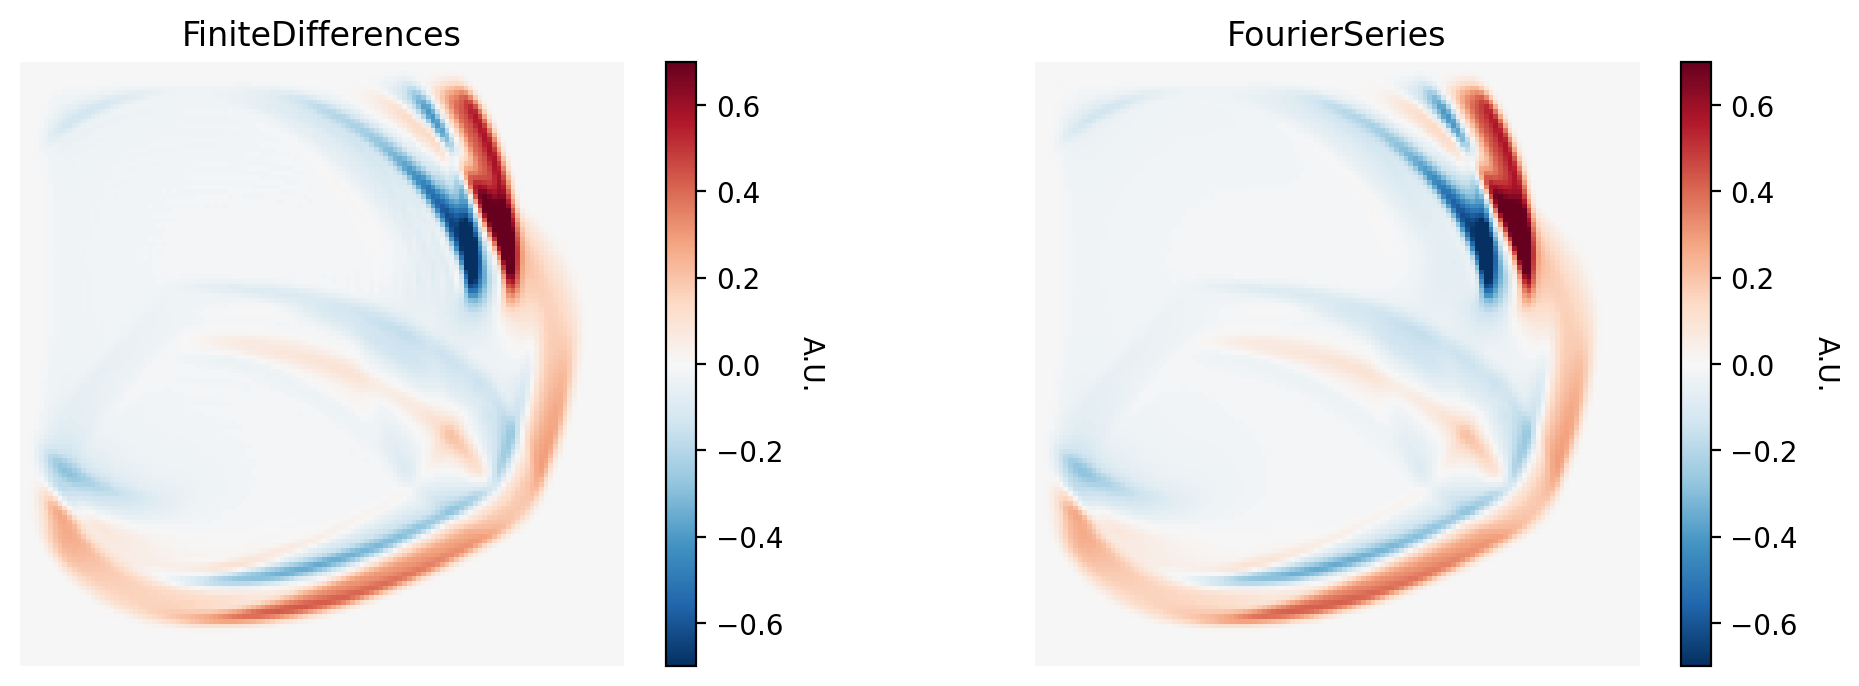

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=200)

im1 = ax[0].imshow(pred_fields_fd[-1].on_grid, cmap="RdBu_r", vmin=-0.7, vmax=0.7)
cbar = fig.colorbar(im1, ax=ax[0])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[0].axis('off')
ax[0].set_title('FiniteDifferences')

im2 = ax[1].imshow(pred_fields_fourier[-1].on_grid, cmap="RdBu_r", vmin=-0.7, vmax=0.7)
cbar = fig.colorbar(im2, ax=ax[1])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[1].axis('off')
ax[1].set_title('FourierSeries')

#plt.savefig("fourier_fd_comparison.pgf")